In [11]:
# Setup
import numpy as np
import pickle
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from statsforecast import StatsForecast
from statsforecast.models import AutoETS
from prophet import Prophet

# Multiple outputs per cell
%config InteractiveShell.ast_node_interactivity = 'all'

# Functions
def create_hour_minute(df):
    '''
    This function is supplemental to the following 'add_time_features' function,
    creating an hour_minute variable
    '''
    # Initialize empty variable
    df['hour_minute'] = None

    # Conditions
    conditions = [df['utc_timestamp'].dt.minute == 15,
                  df['utc_timestamp'].dt.minute == 30,
                  df['utc_timestamp'].dt.minute == 45]
    
    transform = [df['utc_timestamp'].dt.hour + .25,
                 df['utc_timestamp'].dt.hour + .5,
                 df['utc_timestamp'].dt.hour + .75]
    
    # given conditions, transform 
    converted_times = np.select(conditions, transform, df['utc_timestamp'].dt.hour)

    return converted_times

def create_window_idx(data, num_windows=24):
    # indices to loop over for get mae across 24 samples
    impute_windows = list(data.sample(num_windows, random_state=24).index)
    return impute_windows

def create_impute_groups(data, y):
    '''
    Given dataframe with variable to impute, returns 
    a group number for that NA, how many consecutive
    NAs there are, and the first + last index values of 
    the consecutive NAs
    '''
    # note NA values in dataframe
    df = (data.set_index('utc_timestamp') # data or self.data
            .isna()
            .reset_index(drop=True)
          )
    
    # Assign groups of NAs a unique group number
    group_num = 0
    groups = [0]
    for i in range(len(df[y].values)-1): # y or self.y
        value = df[y].values[i]
        next_value = df[y].values[i+1]

        if value == False and next_value == True:
            group_num += 1
        if next_value == None:
            continue
        if value == False:
            groups.append(0)
        else: 
            groups.append(group_num)

    # Add na groups and index columns to df
    df['missing_group_num'] = groups 
    df['index'] = list(range(0, len(df)))

    missing_lengths = (df.groupby('missing_group_num', as_index=False)
                       .agg(consecutive = ('missing_group_num', 'count'),
                            first_na_idx = ('index', 'min'),
                            # adding 2 to last index for imputation
                            last_na_idx = ('index', lambda x: x.max() + 2)) 
                       .iloc[1:] # remove non_na groups
                       .sort_values('first_na_idx')
                       )
    
    return missing_lengths

def forecast_impute(data, y, model_type='AutoETS'): # AutoETS AAA
    '''
    function description
    '''
    # from statsforecast import StatsForecast
    # from statsforecast.models import AutoETS
    data = data.reset_index(drop=True)
    impute_info = create_impute_groups(data, y) 
        
    first_na = impute_info['first_na_idx'].iloc[0] 

    # Defining start, end, and horizon points of training window
    one_year_data = 2880 * 12 # Selecting all data available, up to 1 year
    start = max(first_na - one_year_data, 0)  
    end = first_na - 1 # first_na - 1, or first_na?
    
    horizon = impute_info['consecutive'].iloc[0]
    fcst_df = (data.iloc[start:end] 
            .assign(index = 1) 
            [['index', 'utc_timestamp', y]]) # --- This needs to be generalized

    if model_type == 'AutoETS':
        pd.options.mode.chained_assignment = None

        fcst_df = (data.iloc[start:end] 
            .assign(index = 1) 
            [['index', 'utc_timestamp', y]])

        impute_model = StatsForecast(
            models=[AutoETS(model='AAA', season_length=96)], # --- season_length=96 (1 day) or maybe 1 week
            freq='15min', # --- Needs generalizaiton
            n_jobs=-1,
            verbose=False
            ) 

        result = impute_model.forecast(
            df=fcst_df, 
            id_col='index',
            time_col='utc_timestamp', # --- Needs generalization 
            target_col=y, # --- Needs generalization
            h=horizon,
            # show progress = False,
            ).rename(columns={'AutoETS': 'imputed'})
        
        return result['imputed'] # --- Needs generalization
    
    if model_type == 'Prophet':
        fcst_df = (data.iloc[start:end] 
           .rename(columns={'utc_timestamp': 'ds',
                             f"{y}": 'y'})
            [['ds', 'y']])
            
        fcst_df['ds'] = fcst_df['ds'].dt.tz_localize(None)
        
        model = (Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            seasonality_mode='additive',
            )
            .add_seasonality(name='intraday', 
                             period=96/2,  # (4 * 24 / 2) 15 min intervals
                             fourier_order=4)
            .fit(fcst_df[1:])) # ds and y only
        # further improvement if holidays are added

        # create dataframe of length horizon with the ds component
        predict_window = (data.iloc[first_na-1:first_na+horizon-1]
                          .rename(columns={'utc_timestamp': 'ds'})
                          [['ds']])
        predict_window['ds'] = predict_window['ds'].dt.tz_localize(None)        
        
        result = (model.predict(predict_window)
                  .rename(columns={'yhat': 'to_impute'}))
        
        return result['to_impute'] # --- Needs generalization
    
def create_impute_data(data):
    '''
    Creates main dataset for this experiment, which includes day,
    weekday, and hour_minute. The chosen country, 'AT' (Austria),
    has complete data, making experimentation easy. 
    '''
    impute_data = (data.assign(
            day = lambda x: x['utc_timestamp'].dt.day,
            weekday = lambda x: x['utc_timestamp'].dt.strftime('%a'),
            hour_minute = lambda x: create_hour_minute(x)
        )
        .loc[lambda x: x.country == 'AT']
        .reset_index(drop=True)
        ) 

    return impute_data

def create_weekday_impute(data):
    '''
    Creates average over a weekday time period, 
    for imputing load_actal_entsoe_transparency values.
    '''
    # Weekday impute method
    weekday_impute = (data.groupby(['weekday', 'hour_minute'], as_index=False)
                    .agg(avg_weekday_actuals = ('load_actual_entsoe_transparency', lambda x: x.mean().round(2)))
                    )
    week_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    weekday_impute['weekday'] = pd.Categorical(
        weekday_impute['weekday'], 
        categories=week_order, 
        ordered=True
        )
    weekday_impute = weekday_impute.sort_values(by=['weekday','hour_minute'])
    
    return weekday_impute

In [2]:
# Read in data for developing imputation method
cd = Path.cwd()
data_dir = str(cd.parents[1])
load_energy_dt = data_dir + '/datasets/country_energy/country_load.pickle'

# Read pickle data 
with open(load_energy_dt, 'rb') as f:
    country_actuals = (pickle.load(f)[['utc_timestamp', 'country', 'load_actual_entsoe_transparency']])

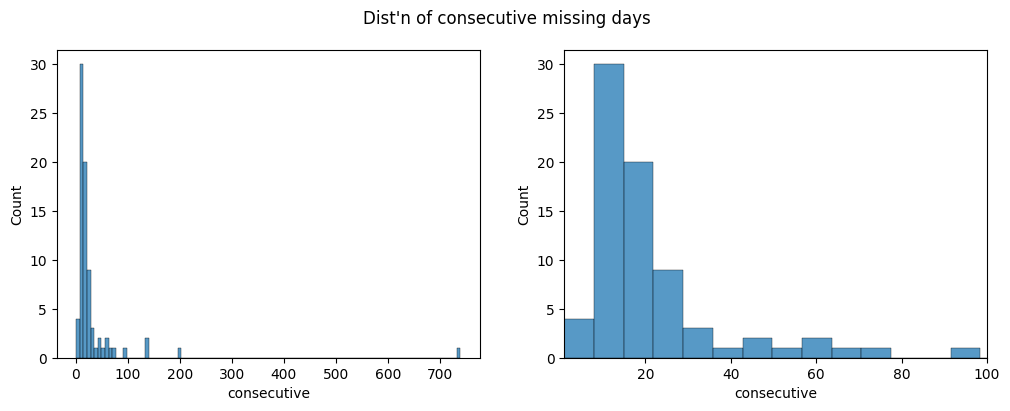

In [3]:
missing_lengths = create_impute_groups(country_actuals, 'load_actual_entsoe_transparency')

# Hist of missing lengths, omitting complete data
fig, ax = plt.subplots(1, 2, figsize=(12,4))
_ = sns.histplot(data=missing_lengths[1:], x='consecutive', stat='count', ax=ax[0])
_ = sns.histplot(data=missing_lengths[1:], x='consecutive', stat='count', ax=ax[1])
_ = ax[1].set_xlim(1,100)
_ = plt.suptitle("Dist'n of consecutive missing days")
plt.show()

In [4]:
country_actuals.head()

,utc_timestamp,country,load_actual_entsoe_transparency
0,2014-12-31 23:15:00+00:00,AT,6088.0
1,2014-12-31 23:30:00+00:00,AT,6060.0
2,2014-12-31 23:45:00+00:00,AT,5957.6
3,2015-01-01 00:00:00+00:00,AT,6017.2
4,2015-01-01 00:15:00+00:00,AT,5966.8


In [5]:
test = country_actuals.set_index('utc_timestamp').isna().reset_index(drop=True)
test
group_num = 0 
groups = [0] ### --- Problem is that 'to_impute' must be hardcoded
for i in range(len(test['load_actual_entsoe_transparency'].values)-1): # y or self.y
    value = test['load_actual_entsoe_transparency'].values[i]
    next_value = test['load_actual_entsoe_transparency'].values[i+1]

    if value == False and next_value == True:
        group_num += 1
    if next_value == None:
        continue
    if value == False:
        groups.append(0)
    else: 
        groups.append(group_num)
# groups
sum(groups)
create_impute_groups(country_actuals, 'load_actual_entsoe_transparency')

,country,load_actual_entsoe_transparency
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
910669,False,False
910670,False,False
910671,False,False
910672,False,False


148843

,missing_group_num,consecutive,first_na_idx,last_na_idx
1,1,1,151779,151781
2,2,9,289359,289369
3,3,1,303558,303560
4,4,20,448481,448502
5,5,47,449094,449142
...,...,...,...,...
76,76,16,905955,905972
77,77,12,905991,906004
78,78,24,906011,906036
79,79,9,906062,906072


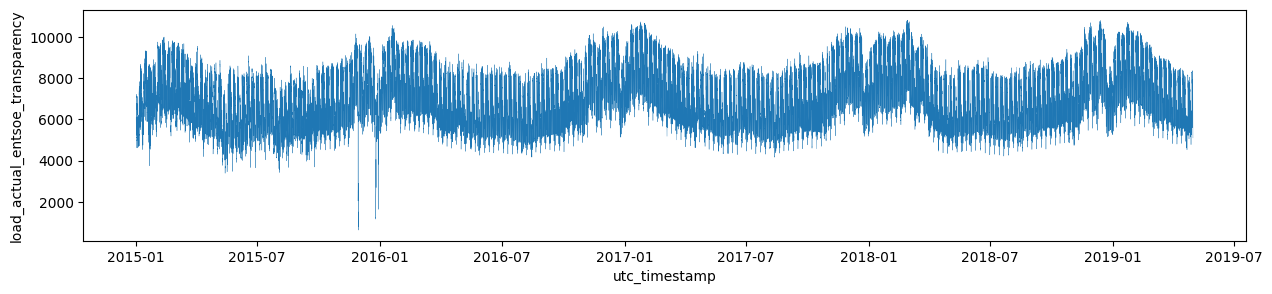

In [6]:
### Developing imputation algorithm with AT due 
# # to there being a full dataset
plot_dt = country_actuals.loc[lambda x: x.country == 'AT']

_ = plt.figure(figsize=(15, 3))

_ = sns.lineplot(
    data=plot_dt, 
    x='utc_timestamp', 
    y='load_actual_entsoe_transparency', 
    linewidth=0.25)

plt.show()

Seasonal decompose

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
151773   NaN
151774   NaN
151775   NaN
151776   NaN
151777   NaN
Name: trend, Length: 151778, dtype: float64
0        -1042.566418
1        -1109.452742
2        -1175.620687
3        -1169.283256
4        -1229.987633
             ...     
151773    -844.839820
151774    -934.581514
151775    -971.737440
151776   -1058.691035
151777   -1122.033658
Name: seasonal, Length: 151778, dtype: float64
0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
151773   NaN
151774   NaN
151775   NaN
151776   NaN
151777   NaN
Name: resid, Length: 151778, dtype: float64


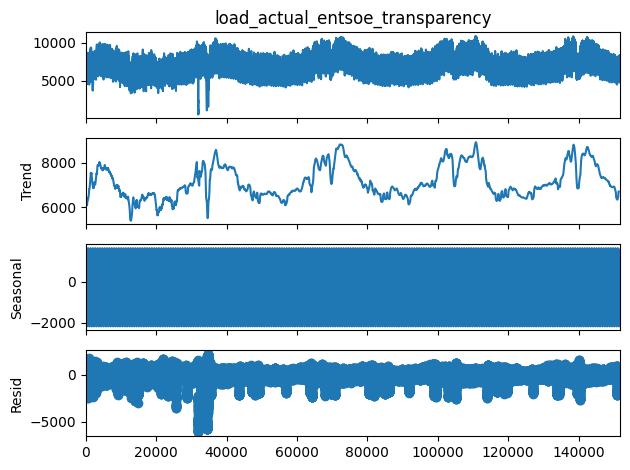

0         5632.037529
1         5633.421512
2         5634.804972
3         5636.187906
4         5637.570315
             ...     
151774            NaN
151775            NaN
151776            NaN
151777            NaN
151778            NaN
Name: trend, Length: 151779, dtype: float64
0         280.653448
1         283.078048
2         247.788498
3         214.867797
4         191.307370
             ...    
151774           NaN
151775           NaN
151776           NaN
151777           NaN
151778           NaN
Name: season, Length: 151779, dtype: float64
0         175.309023
1         143.500440
2          75.006531
3         166.144297
4         137.922315
             ...    
151774           NaN
151775           NaN
151776           NaN
151777           NaN
151778           NaN
Name: resid, Length: 151779, dtype: float64


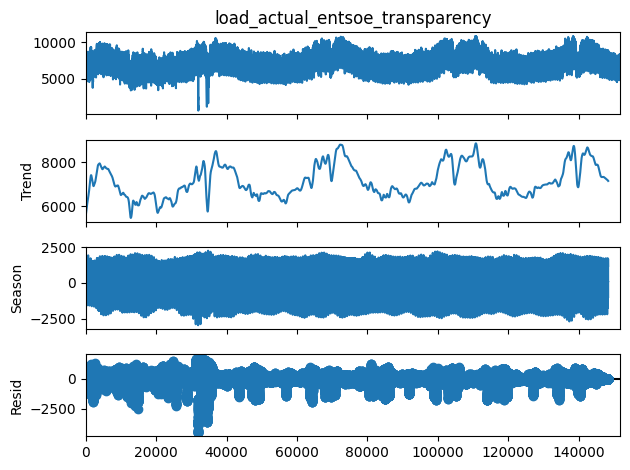

In [12]:
# Create seasonal weekday impute
# naive implementation
from statsmodels.tsa.seasonal import seasonal_decompose
# computationally intensive implementations
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import MSTL
from matplotlib import pyplot
input_data = create_impute_data(country_actuals)

# removing missing value at end
seasonal_impute_df = input_data['load_actual_entsoe_transparency'][:-1]

# How to get seasonal decomposition with missing data?
result = seasonal_decompose(
    seasonal_impute_df, 
    model='additive',
    period = 96 * 7# 96 * 7, 96 * 365.25 
    )
print(result.trend)
print(result.seasonal)
print(result.resid)
_ = result.plot()
pyplot.show()

result = STL(input_data['load_actual_entsoe_transparency'],
          period= 96 * 7).fit() # 96 * 7, 96 * 365.25
print(result.trend)
print(result.seasonal)
print(result.resid)
_ = result.plot()
plt.show()

# result = MSTL(input_data['load_actual_entsoe_transparency'],
#           period= 96 * 7).fit() # 96 * 7, 96 * 365.25
# print(result.trend)
# print(result.seasonal)
# print(result.resid)
# _ = result.plot()
# plt.show()

In [14]:
# Plot of average load shape by day
input_data = create_impute_data(country_actuals)
weekday_impute = create_weekday_impute(input_data)

px.line(
    weekday_impute, 
    x="hour_minute", 
    y="avg_weekday_actuals", 
    color='weekday', 
    facet_col='weekday',
    title="AT Hourly Profiles by Weekday"
    )

# day_hour is not so easy to plot


In [15]:
def create_impute_window(data, n, idx, forecast=False): 
    '''
    Creates imputation window with n NAs at index idx. 
    Window:
        1 row of available data, 
        n rows of NAs, 
        2 rows of available data
    
    If forecast=True, then there is up to 6months of data before NA values.
    
    This is done to ensure all imputation methods can impute without error
    '''

    window = data.iloc[idx-1:idx+n+2]
    window['to_impute'] = window['load_actual_entsoe_transparency'];  
    window.loc[idx:idx+n-1, 'to_impute'] = np.nan

    # forecast impute window, which has additional data for forcasting
    if forecast:
        ### Future: consider dynamic forecast window
        one_year_data = int((2880 * 12) / 2) # Selecting all data available, up to 6 months
        fcst_start = max(idx - one_year_data, 0) 
        fcst_window = data.iloc[fcst_start:idx+n+2]
        fcst_window['to_impute'] = fcst_window['load_actual_entsoe_transparency'];  
        fcst_window.loc[idx:idx+n-1, 'to_impute'] = np.nan

        return fcst_window
    
    return window

In [16]:
### Goal: Use Nixtla ETS model to forecast gaps
# 1. Randomly place gaps in dataset of size n = 4 through 96

### --- This is the dataframe for testing --- ###

# To reflect actual data and favor this forecasting imputation
# method, ensuring first x rows of data are available. 

# 1 day = 96 rows, 1 month = 96 * 30 = 2880
impute_data = create_impute_data(country_actuals)

impute_data['to_impute'] = impute_data['load_actual_entsoe_transparency']
complete_range = impute_data.iloc[0:2879]
impute_range = impute_data.iloc[2879:]
nan_window = list(range(2, 96+1, 2)) # (gaps of size 2 to 96 by 2)
impute_indices = list(impute_range.sample(len(nan_window), random_state=24).index)

# -------- This method does not seem to impute enough nans
for idx, num_nan in zip(impute_indices, nan_window):
    impute_range.iloc[idx:idx+num_nan] = np.nan


### num nan should be very close to 
# (possibility of overlapping windows)
check_nan_num = sum(list(range(2,96+1,2))) 
actual_nan_num = sum(impute_range['to_impute'].isna())

# NA in df is not close to the expected number... 
print(f"Imputed NA num: {check_nan_num}, NA in df: {actual_nan_num}")

# no gaps are large enough to correspond to this difference
final_impute_df = pd.concat([complete_range, impute_range])

Imputed NA num: 2352, NA in df: 2281


Investigating difference in number of NAs

In [17]:
idx_gap_pairs = pd.DataFrame({
    'idx': impute_indices,
    'n_gap_size': nan_window
    })

lag_test = pd.DataFrame({
    'sorted': sorted(impute_indices)
    })

lag_test['sorted_lag'] = lag_test['sorted'].shift()
lag_test['diff'] = lag_test['sorted'] - lag_test['sorted_lag']

final_tbl = (lag_test.merge(
    idx_gap_pairs, 
    left_on='sorted', 
    right_on='idx', 
    how='left')
    [['sorted', 'diff', 'n_gap_size']])

# Cases where the gap is greter than the different, 
# causeing there to be fewer than expected NAs
final_tbl.loc[lambda x: x['diff'] <= x['n_gap_size']]

,sorted,diff,n_gap_size
8,35133,19.0,68


This above table explains a portion of the gap between expected NAs and actual NAs
in the dataframe. 

NA_gap = 2352 - 2281 = 71  
Expected missing NAs = 68 - 19 = 49

Unfortunately, 71 - 49 = 22 missing NAs unexpectedly exist. Currently unaware of their origin.

In [18]:
from statsforecast import StatsForecast
from statsforecast.models import AutoETS

### Check if function can forecast with the non-na values - what happens?
# If it breaks, remove the two prior to forecasting, then recombine later

# indice of first NA value
impute_info = create_impute_groups(final_impute_df, 'load_actual_entsoe_transparency') 
impute_info.head()

first_na = impute_info['first_na_idx'].iloc[0] # for later: final_impute_df

# Defining start, end, and horizon points of training window
one_year_data = 2880 * 12 # Selecting all data available, up to 1 year
start = max(first_na - one_year_data, 0)  
end = first_na - 1

horizon = impute_info['consecutive'].iloc[0]

print(f"first_na: {first_na}, one_year_idx: {one_year_data}",
      f"suggested start: {first_na - one_year_data},",
      f"start: {start}, end: {end}, horizon: {horizon}")

# trying freq=1 assuming one is the number of rows
# the horizon may be an alternative?
impute_model = StatsForecast(
    models=[AutoETS(model="AAA", season_length=96)], # --- season_length=96 (1 day) or maybe 1 week
    freq='15min',
    n_jobs=-1,
    verbose=True
    ) 

# forecast imputed values with forecast df
import time
begin_timing = time.time()
fcst_df = (final_impute_df.iloc[start:end] # index may need to be reset
           #.reset_index()
           #.assign(index = lambda x: x['index'].astype('category'))
           .assign(index = 1)
           [['index', 'utc_timestamp', 'to_impute']]) 

fcst_df.dtypes
fcst_df.shape 

result = impute_model.forecast(
    df=fcst_df, 
    id_col='index',
    time_col='utc_timestamp',
    target_col='to_impute',
    h=horizon
    ).rename(columns={'AutoETS': 'imputed'})

total_time = time.time() - start 

result.head()
# print(f"Total time to train AutoETS Model to impute {horizon} nans ",
#       f"given dataset of size {len(fcst_df)}: {total_time:2f} seconds")

# place imputation into the data from for the given indice range

,missing_group_num,consecutive,first_na_idx,last_na_idx
1,1,24,6052,6077
2,2,60,6601,6662
3,3,50,11487,11538
4,4,36,20487,20524
5,5,82,26193,26276


first_na: 6052, one_year_idx: 34560 suggested start: -28508, start: 0, end: 6051, horizon: 24


index                          int64
utc_timestamp    datetime64[ns, UTC]
to_impute                    float64
dtype: object

(6051, 3)

Forecast:   0%|          | 0/1 [00:00<?, ?it/s]

,index,utc_timestamp,imputed
0,1,2015-03-05 00:00:00+00:00,7016.370734
1,1,2015-03-05 00:15:00+00:00,6931.056460
2,1,2015-03-05 00:30:00+00:00,6948.100639
3,1,2015-03-05 00:45:00+00:00,6887.453011
4,1,2015-03-05 01:00:00+00:00,6888.810414


In [ ]:
%%capture
import gc

impute_data = create_impute_data(country_actuals)
impute_windows = create_window_idx(impute_data)
weekday_impute = create_weekday_impute(impute_data)

# Outer loop
final_results = pd.DataFrame({}) # concat the results from inner loop to the outer loop
for n in range(96,97): # 96 range(2, 4, 2):
    # pd.options.mode.chained_assignment = None --- This may belong in the forecast impute for the AutoETS method
    lin_nearest_mae = 0
    lin_linear_mae = 0
    spline_mae = 0
    poly_mae = 0
    weekday_actuals_mae = 0
    fcst_mae = 0 
    fcst_smooth_mae = 0
    prophet_fcst_mae = 0
    prophet_fcst_smooth_mae = 0
    # Inner loop
    for idx in impute_windows[:8]: # 24 windows total (only doing first 4)
        # pd.options.mode.chained_assignment = None --- This may belong in the forecast impute for the AutoETS method
        # Create dataset for imputation
        window = create_impute_window(impute_data, n, idx)

        # Weekday average impute method
        window = window.merge(weekday_impute, how='left', on=['weekday', 'hour_minute'])

        # Interpolation impute methods
        window['lin_nearest_impute'] = window['to_impute'].interpolate(method="nearest")
        window['lin_linear_impute'] = window['to_impute'].interpolate(method="linear")
        window['spline_impute'] = window['to_impute'].interpolate(method="spline", order=2)

        # imputation with forecasting
        fcst_window = create_impute_window(impute_data, n, idx, forecast=True)

        # fcst_impute with load_actual, horizon chosen within, then add rows to the window to calculate the MAE
        # fcst_impute = forecast_impute(fcst_window, 'to_impute', model_type='Prophet')
        fcst_impute = forecast_impute(fcst_window, 'to_impute', model_type='AutoETS') 
        prophet_fcst_impute = forecast_impute(fcst_window, 'to_impute', model_type='Prophet') 
        del fcst_window
        first_value = window['to_impute'][0]
        last_values = window['to_impute'][-2:].values
        fcst_imputed = [first_value, *fcst_impute.values, *last_values]
        prophet_fcst_imputed = [first_value, *prophet_fcst_impute.values, *last_values]

        window['fcst_imputed'] = fcst_imputed
        window['fcst_impute_smooth'] = pd.Series(fcst_imputed).ewm(alpha=.5).mean()
        window['prophet_fcst_imputed'] = prophet_fcst_imputed
        window['prophet_fcst_imputed_smooth'] = pd.Series(prophet_fcst_imputed).ewm(alpha=.5).mean()

        
        #print(f"len window: {len(window)}")
        
        # --- Modify: window['smoothed_2'] = fl_result.imputed.ewm(alpha=.5).mean()

        # Add mae per impute method (Will later average)
        lin_nearest_mae += mean_absolute_error(
            window['load_actual_entsoe_transparency'], 
            window['lin_nearest_impute']
            )
        lin_linear_mae += mean_absolute_error(
            window['load_actual_entsoe_transparency'], 
            window['lin_linear_impute']
            )
        spline_mae += mean_absolute_error(
            window['load_actual_entsoe_transparency'], 
            window['spline_impute']
            )
        weekday_actuals_mae += mean_absolute_error(
            window['load_actual_entsoe_transparency'], 
            window['avg_weekday_actuals']
            )
        fcst_mae += mean_absolute_error(
            window['load_actual_entsoe_transparency'], 
            window['fcst_imputed']
            )
        prophet_fcst_mae += mean_absolute_error(
            window['load_actual_entsoe_transparency'], 
            window['prophet_fcst_imputed']
            )
        fcst_smooth_mae = mean_absolute_error(
            window['load_actual_entsoe_transparency'], 
            window['fcst_impute_smooth']
            )
        prophet_fcst_smooth_mae = mean_absolute_error(
            window['load_actual_entsoe_transparency'], 
            window['prophet_fcst_imputed_smooth']
            )

    avg_lin_nearest_mae = np.round(lin_nearest_mae / 24, 2)
    avg_lin_linear_mae = np.round(lin_linear_mae / 24, 2)
    avg_spline_mae = np.round(spline_mae / 24, 2)
    #avg_poly_mae = np.round(poly_mae / 24, 2)
    avg_fcst_mae = np.round(fcst_mae / 24, 2)
    prophet_fcst_smooth_mae = np.round(prophet_fcst_smooth_mae / 24, 2)

    result = pd.DataFrame({
        "n": [n],
        "avg_lin_nearest_mae": [avg_lin_nearest_mae],
        "avg_lin_linear_mae": [avg_lin_linear_mae],
        "avg_spline_mae": [avg_spline_mae], 
        #"avg_poly_mae": [avg_poly_mae],
        "avg_weekday_actuals_mae": [weekday_actuals_mae],
        "avg_fcst_mae": [fcst_mae],
        "avg_prophet_fcst_mae": [prophet_fcst_mae],
        "avg_fcst_smooth_mae": [fcst_smooth_mae],
        "avg_prophet_fcst_smooth_mae": [prophet_fcst_smooth_mae],
    })

    final_results = pd.concat([final_results, result])

    # gc.collect()

In [100]:
final_results 

,n,avg_lin_nearest_mae,avg_lin_linear_mae,avg_spline_mae,avg_weekday_actuals_mae,avg_fcst_mae,avg_prophet_fcst_mae,avg_fcst_smooth_mae
0,96,365.64,372.9,720.6,4699.954949,5835.236534,4250.993399,52.41


### Experiment Graveyard

Below are remnants of some experiments. 

In [24]:
### Goal: Use Nixtla ETS model to forecast gaps
# 1. Randomly place gaps in dataset of size n = 4 through 96

### --- This is the dataframe for testing --- ###

# To reflect actual data and favor this forecasting imputation
# method, ensuring first x rows of data are available. 

impute_data = create_impute_data(country_actuals)

# 1 day = 96 rows, 1 month = 96 * 30 = 2880
impute_data['to_impute'] = impute_data['load_actual_entsoe_transparency']
complete_range = impute_data.iloc[0:2879]
impute_range = impute_data.iloc[2879:]
nan_window = list(range(2, 96+1, 2)) # (gaps of size 2 to 96 by 2)
impute_indices = list(impute_range.sample(len(nan_window), random_state=24).index)

# -------- This method does not seem to impute enough nans
for idx, num_nan in zip(impute_indices, nan_window):
    impute_range.iloc[idx:idx+num_nan] = np.nan


### num nan should be very close to 
# (possibility of overlapping windows)
check_nan_num = sum(list(range(2,96+1,2))) 
actual_nan_num = sum(impute_range['to_impute'].isna())

# NA in df is not close to the expected number... 
print(f"Imputed NA num: {check_nan_num}, NA in df: {actual_nan_num}")

# no gaps are large enough to correspond to this difference
final_impute_df = pd.concat([complete_range, impute_range])

Imputed NA num: 2352, NA in df: 2281


In [25]:
idx_gap_pairs = pd.DataFrame({
    'idx': impute_indices,
    'n_gap_size': nan_window
    })

lag_test = pd.DataFrame({
    'sorted': sorted(impute_indices)
    })

lag_test['sorted_lag'] = lag_test['sorted'].shift()
lag_test['diff'] = lag_test['sorted'] - lag_test['sorted_lag']

final_tbl = (lag_test.merge(
    idx_gap_pairs, 
    left_on='sorted', 
    right_on='idx', 
    how='left')
    [['sorted', 'diff', 'n_gap_size']])

# Cases where the gap is greter than the different, 
# causeing there to be fewer than expected NAs
final_tbl.loc[lambda x: x['diff'] <= x['n_gap_size']]

,sorted,diff,n_gap_size
8,35133,19.0,68


In [26]:
from statsforecast import StatsForecast
from statsforecast.models import AutoETS


### Check if function can forecast with the non-na values - what happens?
# If it breaks, remove the two prior to forecasting, then recombine later

# indice of first NA value
impute_info = create_impute_groups(final_impute_df, 'load_actual_entsoe_transparency') 
impute_info.head()

first_na = impute_info['first_na_idx'].iloc[0] # for later: final_impute_df

# Defining start, end, and horizon points of training window
one_year_data = 2880 * 12 # Selecting all data available, up to 1 year
start = max(first_na - one_year_data, 0)  
end = first_na - 1

horizon = impute_info['consecutive'].iloc[0]

print(f"first_na: {first_na}, one_year_idx: {one_year_data}",
      f"suggested start: {first_na - one_year_data},",
      f"start: {start}, end: {end}, horizon: {horizon}")

# trying freq=1 assuming one is the number of rows
# the horizon may be an alternative?
impute_model = StatsForecast(
    models=[AutoETS(model="AAA", season_length=96)], # --- season_length=96 (1 day) or maybe 1 week
    freq='15min',
    n_jobs=-1,
    verbose=True
    ) 

# forecast imputed values with forecast df
import time
begin_timing = time.time()
fcst_df = (final_impute_df.iloc[start:end] # index may need to be reset
           #.reset_index()
           #.assign(index = lambda x: x['index'].astype('category'))
           .assign(index = 1)
           [['index', 'utc_timestamp', 'to_impute']]) 

fcst_df.dtypes
fcst_df.shape 

result = impute_model.forecast(
    df=fcst_df, 
    id_col='index',
    time_col='utc_timestamp',
    target_col='to_impute',
    h=horizon
    ).rename(columns={'AutoETS': 'imputed'})

total_time = time.time() - start 

result.head()
# print(f"Total time to train AutoETS Model to impute {horizon} nans ",
#       f"given dataset of size {len(fcst_df)}: {total_time:2f} seconds")

# place imputation into the data from for the given indice range

,missing_group_num,consecutive,first_na_idx,last_na_idx
1,1,24,6052,6077
2,2,60,6601,6662
3,3,50,11487,11538
4,4,36,20487,20524
5,5,82,26193,26276


first_na: 6052, one_year_idx: 34560 suggested start: -28508, start: 0, end: 6051, horizon: 24


index                          int64
utc_timestamp    datetime64[ns, UTC]
to_impute                    float64
dtype: object

(6051, 3)

Forecast:   0%|          | 0/1 [00:00<?, ?it/s]

,index,utc_timestamp,imputed
0,1,2015-03-05 00:00:00+00:00,7016.370734
1,1,2015-03-05 00:15:00+00:00,6931.056460
2,1,2015-03-05 00:30:00+00:00,6948.100639
3,1,2015-03-05 00:45:00+00:00,6887.453011
4,1,2015-03-05 01:00:00+00:00,6888.810414


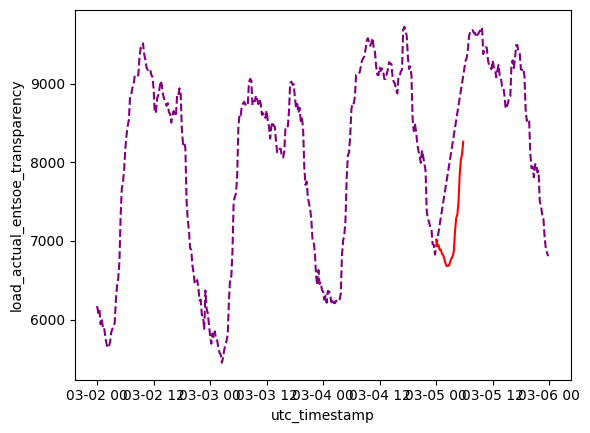

In [27]:
# Plot results of the forecast
# For the loop, simply set the range of index values to the result where AutoETS -> to_impute

end_date = max(result['utc_timestamp'])
start_date = end_date - pd.Timedelta(days=3) 

# This can probably be combined with the smoothing window
date_range = pd.date_range(start=start_date, end=end_date, freq='15min')
actuals = impute_data[impute_data['utc_timestamp'].dt.date.isin(date_range.date)]

_ = sns.lineplot(data=actuals, x='utc_timestamp', y='load_actual_entsoe_transparency', 
             color='purple', linestyle='--')
_ = sns.lineplot(data=result, x='utc_timestamp', y='imputed', color='red')
#set(xlim=(start_date, end_date))
plt.show()

,utc_timestamp,country,load_actual_entsoe_transparency,weekday,hour_minute,to_impute
6075,2015-03-05 06:00:00+00:00,AT,9198.8,Thu,6.0,9198.8


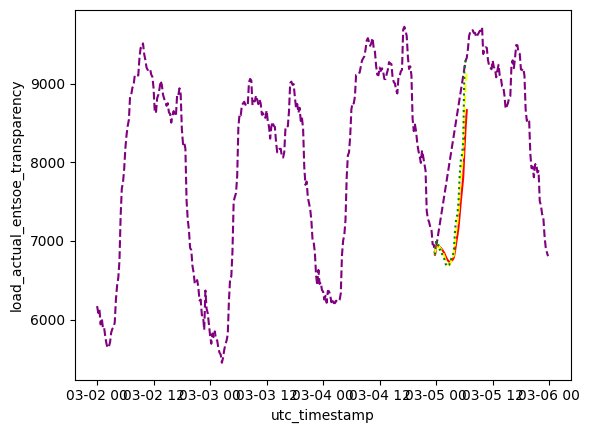

In [29]:
# Something with ewm

# Get the result, append the actuals 1 before and 1 after
# experiment with awm with different values of alpha. Plot the results. 
start_date = min(result['utc_timestamp']) - pd.Timedelta('15m')
first = impute_data[impute_data['utc_timestamp'] == start_date]
first = pd.DataFrame({
    'index': [1],
    'utc_timestamp': pd.to_datetime(first['utc_timestamp'].values[0], utc=True),
    'imputed': first['to_impute'].values[0],
    })

end_date = max(result['utc_timestamp']) + pd.Timedelta('15m') # 15 * 5
last = impute_data[impute_data['utc_timestamp'] == end_date]
last
last = pd.DataFrame({
    'index': [1],
    'utc_timestamp': pd.to_datetime(last['utc_timestamp'].values[0], utc=True),
    'imputed': last['to_impute'].values[0],
    })

# Goal: have last add 5 values rather than just 1 (perhaps as a loop) --- to test how smoothing will perform with automation function
for _ in range(2):
    end_date = max(last['utc_timestamp']) + pd.Timedelta('15m') # 15 * 5
    add_end_date = impute_data[impute_data['utc_timestamp'] == end_date]
    add = pd.DataFrame({
        'index': [1],
        'utc_timestamp': pd.to_datetime(add_end_date['utc_timestamp'].values[0], utc=True),
        'imputed': add_end_date['to_impute'].values[0],
        })
    last = pd.concat([last, add])

fl_result = pd.concat([first, result, last]).reset_index(drop=True)
fl_result['smoothed_1'] = fl_result.imputed.ewm(alpha=.25).mean()
fl_result['smoothed_2'] = fl_result.imputed.ewm(alpha=.5).mean()
fl_result['smoothed_3'] = fl_result.imputed.ewm(alpha=1).mean()

_ = sns.lineplot(data=actuals, x='utc_timestamp', y='load_actual_entsoe_transparency', 
             color='purple', linestyle='--')
_ = sns.lineplot(data=fl_result, x='utc_timestamp', y='smoothed_1', color='red')
_ = sns.lineplot(data=fl_result, x='utc_timestamp', y='smoothed_2', color='yellow', linestyle='--')
_ = sns.lineplot(data=fl_result, x='utc_timestamp', y='smoothed_3', color='green', linestyle=':')

plt.show()


In [30]:
impute_data.head()

,utc_timestamp,country,load_actual_entsoe_transparency,weekday,hour_minute,to_impute
0,2014-12-31 23:15:00+00:00,AT,6088.0,Wed,23.25,6088.0
1,2014-12-31 23:30:00+00:00,AT,6060.0,Wed,23.50,6060.0
2,2014-12-31 23:45:00+00:00,AT,5957.6,Wed,23.75,5957.6
3,2015-01-01 00:00:00+00:00,AT,6017.2,Thu,0.00,6017.2
4,2015-01-01 00:15:00+00:00,AT,5966.8,Thu,0.25,5966.8


In [ ]:
# Skipping for now            # May continue developing above method

# Other methods to consider:
# From sklearn, try IterativeImputer with MissForest and MICE
# IterativeImputer
# Kalman Filtering
# VAE median
# bring in Seasonal Decomposition-Based Imputation (e.g., na_seadec) from R
# For longer gaps in the data from fancyimpute import GAIN (generative adversarial networks) imputed_data = GAIN().fit_transform(df.values)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# random_state=12


# Both kalman filter and GAIN may be better for longer time gaps. 


### DataWig super imputer



In [ ]:
# Seasonal decomposition of the load variable. Examine residuals at 15 minute intervals.
from statsmodels.tsa.seasonal import MSTL

test = impute_data['load_actual_entsoe_transparency'][]

# What are the optimal periods?
mstl = MSTL(
    impute_data['load_actual_entsoe_transparency'], 
    periods=[96, 96 * 7, int(96 * 364.25)], # 1 day, 1 week, 1 year
    )
# stl_kwargs=({"seasonal_deg": 0,
#             "inner_iter": 2,
#             "outer_iter": 0})
# Consider dictionary for trend windows

res = mstl.fit()
ax = res.plot()

plt.tight_layout()

### Time elapsed:
# 105+ minutes

# Untenable!


In [13]:
#impute_data = create_impute_data(country_actuals)
impute_data.columns
impute_data.shape[1]

Index(['utc_timestamp', 'country', 'load_actual_entsoe_transparency',
       'weekday', 'hour_minute'],
      dtype='object')

5

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

impute_data = create_impute_data(country_actuals)

trends = []
resids = []
seasonality = []
decomposition = seasonal_decompose(impute_data['load_actual_entsoe_transparency'])
decomposition
# for col in range(impute_data.shape[1]):
#     decomposition = seasonal_decompose(
#         impute_data[:, col], 
#     )
#     trends.append(decomposition.trend)
#     resids.append(decomposition.resid)
#     seasonality.append(decomposition.seasonal)
# trends = np.vstack(trends).T
# resids = np.vstack(resids).T
# seasonality = np.vstack(seasonality).T

# deseasonalized = trends + resids


ValueError: This function does not handle missing values